<a href="https://colab.research.google.com/github/d-vf/P2PEnergyTrading/blob/main/implementation/P2P_24_hour_block_LP_DC_aprox_21072024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data, Libraries, set-up

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/Diana Vieira Fernandes - Work folder/Qual A/Data")

In [3]:
!apt-get install -y graphviz libgraphviz-dev #data viz
!pip install pygraphviz diagrams # diagrams
!pip install pandapower["all"] #data
! pip install gurobipy #gurobi (MILP)
! pip install scipy #transform .m to .pp
!pip install pydot graphviz # for HG
! pip install plotly #cute plots
! pip install numba #Need for PP pandapower
! pip install -U kaleido #to save png IO

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 45 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgail18 

## Reading from already calculated clusters

In [4]:
import pandas as pd
cluster_medians_solar = pd.read_csv('https://raw.githubusercontent.com/d-vf/P2PEnergyTrading/main/Data/cluster_medians_solar.csv', header=0, sep=',')
cluster_medians = pd.read_csv('https://raw.githubusercontent.com/d-vf/P2PEnergyTrading/main/Data/cluster_medians.csv', header=0, sep=',')
cluster_medians_com = pd.read_csv('https://raw.githubusercontent.com/d-vf/P2PEnergyTrading/main/Data/cluster_medians_com.csv', header=0, sep=',')

## Network

In [5]:
import pandapower as pp
import pandapower.networks as pn
from pandapower.plotting.plotly import vlevel_plotly

net = pn.create_cigre_network_lv()

#net = pp.networks.create_synthetic_voltage_control_lv_network(network_class='village_1')
net.name = "cigre network lv"
fig = vlevel_plotly(net)
fig.update_layout(width=800, height=600)
fig.show()

# Number of buses
n_buses = len(net.bus)

In [6]:
import pandapower as pp
import pandapower.networks as nw
import pandapower.plotting as plot
import networkx as nx
import numpy as np
from scipy.sparse import csr_matrix

# Create a graph from the network
graph = pp.topology.create_nxgraph(net)

# Remove all loads and generations
net.load.drop(net.load.index, inplace=True)
net.sgen.drop(net.sgen.index, inplace=True)
net.gen.drop(net.gen.index, inplace=True)

# Transpose the DataFrame
transposed_df = cluster_medians.T
# Take just the first row (hour 11 for now)
first_row = transposed_df.iloc[:, 11]
#Removing previous values
net.load.drop(net.load.index, inplace=True)

# Find extreme buses (logic is that loads and sgen will be here....)
extreme_buses = [node for node, degree in graph.degree() if degree == 1]

# Calculate 50% of the extreme buses
num_to_add = int(len(extreme_buses) * 0.5)

# Randomly select 50% of the extreme buses
#np.random.shuffle(extreme_buses)
#selected_buses = extreme_buses[:num_to_add]

selected_buses_odd = extreme_buses[1::2][:num_to_add]
selected_buses_even = extreme_buses[0::2][:num_to_add]
#selected_buses = selected_buses_odd[:num_to_add]

# set loads on these
for bus in selected_buses_odd:
    load = first_row.iloc[1]
    q_value = np.abs(load * np.tan(np.arccos(0.99)))
    pp.create_load(net, bus=bus, p_mw=load/1e3,q_mvar=q_value/1e3) #recall that values are in MW

#Removing previous values
net.sgen.drop(net.sgen.index, inplace=True)

# Transpose the DataFrame for solar data
transposed_df_solar = cluster_medians_solar.T

# Take just the first row (hour 11 for now)
first_row_solar = transposed_df_solar.iloc[:, 11]

# Add sgens to the selected buses using solar data
for bus in selected_buses_even:
    #solar_value = first_row_solar[1] #1st cluster
    solar_value = first_row_solar.iloc[1]
    q_value = np.abs(solar_value * np.tan(np.arccos(0.99)))
    pp.create_sgen(net, bus=bus, p_mw=solar_value/1e3, q_mvar=q_value/1e3) #recall that values are in MW

In [7]:
# Run the power flow
pp.rundcpp(net, numba=False) #DC

In [8]:
#Ybus = net["_ppc"]['internal']['Ybus'].todense()
#print(Ybus.shape)

In [9]:
import copy

def update_network_for_hour(net, medians_df, median_solar_df, hour):
    transposed_loads_df = cluster_medians[['Cluster_0']]
    transposed_solar_df = cluster_medians_solar[['Cluster_0']]

    if hour >= len(transposed_loads_df) or hour >= len(transposed_solar_df):
        print("Hour index out of bounds.")
        return

    load_for_hour = transposed_loads_df.iloc[hour, 0]
    solar_for_hour = transposed_solar_df.iloc[hour, 0]

    net.load.drop(net.load.index, inplace=True)
    net.sgen.drop(net.sgen.index, inplace=True)

    graph = pp.topology.create_nxgraph(net)
    extreme_buses = [node for node, degree in graph.degree() if degree == 1]

    selected_buses = extreme_buses[:int(len(extreme_buses) * 0.5)] #50% with sgen

    selected_buses_odd = extreme_buses[1::2][:num_to_add]
    selected_buses_even = extreme_buses[0::2][:num_to_add]

    for bus in selected_buses_even:
        load = load_for_hour  # Assuming each bus will have the same load for the hour
        q_value = np.abs(load * np.tan(np.arccos(0.99)))
        pp.create_load(net, bus=int(bus), p_mw=load/1e3, q_mvar=q_value/1e3)


    for bus in selected_buses_odd:
        solar_value = solar_for_hour  # Assuming each bus will have the same solar value for the hour
        q_value = np.abs(solar_value * np.tan(np.arccos(0.99)))
        pp.create_sgen(net, bus=bus, p_mw=solar_value/1e3, q_mvar=q_value/1e3)

# Initialize a list to store network states for each hour
all_nets = []

# Generate networks for each hour
for hour in range(24):
    # Create a deep copy of the network object for this hour
    net_copy = copy.deepcopy(net)

    # Update the network for the current hour
    update_network_for_hour(net_copy, cluster_medians, cluster_medians_solar, hour)

    # Store the network for this hour
    all_nets.append(net_copy)


In [10]:
all_nets[11].load

,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type
0,None,12,0.002419,0.000345,0.0,0.0,NaN,1.0,True,wye
1,None,17,0.002419,0.000345,0.0,0.0,NaN,1.0,True,wye
2,None,19,0.002419,0.000345,0.0,0.0,NaN,1.0,True,wye
3,None,35,0.002419,0.000345,0.0,0.0,NaN,1.0,True,wye
4,None,37,0.002419,0.000345,0.0,0.0,NaN,1.0,True,wye
5,None,41,0.002419,0.000345,0.0,0.0,NaN,1.0,True,wye


## Elements (Ybus and Capacity)

## adjacency matrix

In [11]:
import numpy as np
import pandas as pd
import math


net_N = pn.create_cigre_network_lv()

#net_N = pp.networks.create_synthetic_voltage_control_lv_network(network_class='village_1')

# Remove all loads and generations to start with 1
net_N.load.drop(net_N.load.index, inplace=True)
net_N.sgen.drop(net_N.sgen.index, inplace=True)
net_N.gen.drop(net_N.gen.index, inplace=True)

# Run the power flow
pp.rundcpp(net_N) #DC

# Initialize an empty adjacency matrix
n_buses = len(net_N.bus)
adj_matrix = np.zeros((n_buses, n_buses))

# Assume a default angle of 30 degrees in radians
delta_rad = math.radians(30)

# Loop over lines to populate adjacency matrix
for i, line in net_N.line.iterrows():
    from_bus = int(line.from_bus)
    to_bus = int(line.to_bus)
    reactance = line.x_ohm_per_km

    v_from = net_N.res_bus.vm_pu.loc[from_bus] * net_N.bus.vn_kv.loc[from_bus]
    v_to = net_N.res_bus.vm_pu.loc[to_bus] * net_N.bus.vn_kv.loc[to_bus]

    p_capacity = (v_from * v_to / reactance) * np.sin(delta_rad)

    adj_matrix[from_bus, to_bus] = p_capacity
    adj_matrix[to_bus, from_bus] = p_capacity

# Loop over transformers
for i, trafo in net_N.trafo.iterrows():
    hv_bus = int(trafo.hv_bus)
    lv_bus = int(trafo.lv_bus)
    sn_mva = trafo.sn_mva

    adj_matrix[hv_bus, lv_bus] = sn_mva
    adj_matrix[lv_bus, hv_bus] = sn_mva


# Loop over external grid connections
for i, eg in net_N.ext_grid.iterrows():
    bus = int(eg.bus)
    p_mw = eg.vm_pu * net_N.bus.vn_kv.loc[bus]

    if bus != 0:
        adj_matrix[0, bus] = p_mw
        adj_matrix[bus, 0] = p_mw

# Loop over switches
for i, switch in net_N.switch.iterrows():
    bus = int(switch.bus)
    element = int(switch.element)

    if switch.closed:
        if switch.et == 'l':  # Line switch
            P_capacity_switch = adj_matrix[bus, element]
        elif switch.et == 't':  # Transformer switch
            P_capacity_switch = adj_matrix[bus, element]
        elif switch.et == 'b':  # Bus switch
            P_capacity_switch = 0  # Set to zero or use your custom logic
    else:
        P_capacity_switch = 0  # Open switch

    adj_matrix[bus, element] = P_capacity_switch
    adj_matrix[element, bus] = P_capacity_switch

ext_grid_bus = net_N.ext_grid.bus.values[0]
#s_sc_max_mva = net_N.ext_grid.s_sc_max_mva.values[0]  # Assuming this is the capacity for ext_grid
s_sc_max_mva = 0

# Connect ext_grid to the transformers using capacity values
for i, hv_bus in enumerate(net_N.trafo.hv_bus.values):
    trafo_capacity = net_N.trafo.sn_mva.values[i]
    adj_matrix[ext_grid_bus, hv_bus] = min(s_sc_max_mva, trafo_capacity)
    adj_matrix[hv_bus, ext_grid_bus] = min(s_sc_max_mva, trafo_capacity)


# Convert to DataFrame
adj_matrix_df = pd.DataFrame(adj_matrix)

In [12]:
adj_matrix_array = adj_matrix_df.to_numpy()

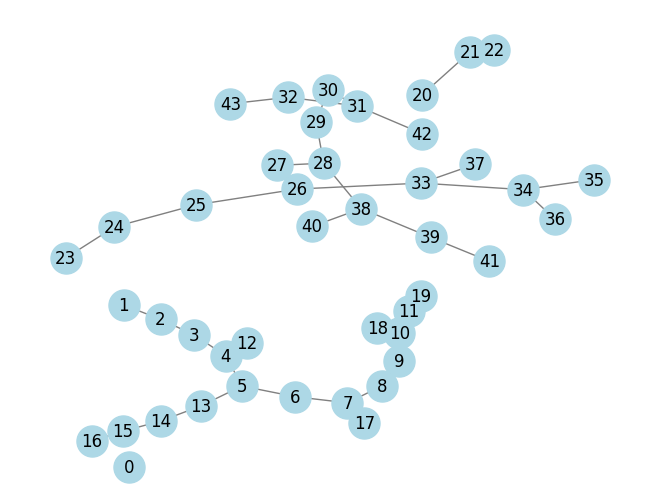

In [13]:
import networkx as nx

from matplotlib import pyplot as plt

# Create graph
G = nx.Graph(adj_matrix_array)

# Plot graph
nx.draw(G, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')
plt.show()

In [15]:
import pandapower as pp
import plotly.graph_objects as go
import pandapower.networks as nw
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout
import pygraphviz as pgv
import pandapower.networks as pn
import plotly.graph_objs as go
import plotly.io as pio
from networkx.drawing.nx_agraph import graphviz_layout
import kaleido

# Create graph
G = nx.Graph(adj_matrix_array)

# Extract the edges from the pandapower graph
edges_from_graph = list(G.edges())

# Extract the edges
edges_from_lines = list(net.line[['from_bus', 'to_bus']].itertuples(index=False))
edges_from_trafos = list(net.trafo[['hv_bus', 'lv_bus']].itertuples(index=False))
edges_from_switches = [(switch.bus, switch.element) for switch in net.switch[net.switch.closed].itertuples(index=False)]


# Create a new directed graph (DiGraph)
G = nx.DiGraph()

# Add the edges from lines and trafos to make it hierarchical
G.add_edges_from(edges_from_lines)
G.add_edges_from(edges_from_trafos)
G.add_edges_from(edges_from_switches)

# Modify node colors
# Remove selected buses from extreme_buses (this was calculate before to assign node, where loads to all with degree less than 1, then 50% get sgen)
extreme_buses_1 = [bus_id for bus_id in extreme_buses if bus_id not in selected_buses_odd]

# Create a dictionary to specify colors for the nodes
node_colors = {node: 'red' if node == 0 else 'green' if node in extreme_buses_1 else 'orange' if node in selected_buses_odd else 'grey' for node in net.bus.index}

# edge colors
edge_colors = {
    (0, 1): 'red',
    (0, 2): 'black',
}

# Get the layout of the graph
pos = graphviz_layout(G, prog="dot")

# Manually adjust the positions of bus 0 and bus 1, 23 to create a vertical alignment
#pos[0] = (549, 1300)
pos[0] = (333, 810)
pos[1] = (333, 810)
pos[23] = (333, 810)

fig = go.Figure()

# Loop through nodes and add them to the plot, set showlegend to False
for node in G.nodes:
    x, y = pos[node]
    color = node_colors.get(node, 'grey')
    fig.add_trace(go.Scatter(x=[x], y=[y], mode='markers',
                             marker=dict(size=10, color=color),
                             text=str(node), showlegend=False))

# Loop through edges and add them to the plot, set showlegend to False
for lv_bus, hv_bus in G.edges:
    x1, y1 = pos[lv_bus]
    x2, y2 = pos[hv_bus]
    color = edge_colors.get((lv_bus, hv_bus), 'black')
    fig.add_trace(go.Scatter(x=[x1, x2], y=[y1, y2], mode='lines',
                             line=dict(width=2, color=color), showlegend=False))
# Add legend with colors
legend_colors = {
    'Bus 0 (Slack)': 'red',
    'Consumers': 'green',
    'Prosumers': 'orange',
    'iddle': 'grey'
}

# legend with colors, attribute set to True
for label, color in legend_colors.items():
    fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers',
                             marker=dict(size=10, color=color),
                             name=label, showlegend=True))


#layout
fig.update_layout(width=800, height=600, plot_bgcolor='white',
                  showlegend=True, legend=dict(orientation='h', x=0, y=1.1),
                  xaxis_visible=False, yaxis_visible=False,
                  font=dict(
                      family="'CMU Serif', serif",  # This is a font resembles LaTeX font
                      size=18,
                      color="black"
    ))

fig.update_yaxes(scaleanchor='x', scaleratio=0.5)


# Show the plot
fig.show()

# Save the figure with high resolution
fig.write_image("images/network_80_WB.pdf", width=800, height=600, scale=2)
#fig.write_image("images/network_80_WB.pdf", width=800, height=600, scale=2)

# Save the DataFrame to a CSV file
#edges_df.to_csv('edges_list.csv', index=False)

## Fixing Ybus

In [16]:
from pandapower.pypower.makeYbus import makeYbus
net_N["_ppc"]['internal']['Ybus']

orphaned_buses = set(net_N.bus.index) - set(net_N.line.from_bus) - set(net_N.line.to_bus) - set(net_N.trafo.hv_bus) - set(net_N.trafo.lv_bus)
if orphaned_buses:
    print(f"Orphaned buses detected: {orphaned_buses}")

print(net_N.ext_grid)

connected_lines = net_N.line[(net_N.line.from_bus == 0) | (net_N.line.to_bus == 0)]
print(connected_lines)

connected_trafos = net_N.trafo[(net_N.trafo.hv_bus == 0) | (net_N.trafo.lv_bus == 0)]
print(connected_trafos)

pp.create_ext_grid(net_N, bus=0, vm_pu=1.0, name="Grid Connection")
bus_hv = 0  # This is the bus where the external grid is connected.
#bus_lv = pp.create_bus(net, vn_kv=20.0, name="LV Bus")
#pp.create_transformer(net, hv_bus=bus_hv, lv_bus=bus_lv, std_type="25 MVA 110/20 kV", name="T1")


Ybus1, Yf, Yt = makeYbus(net_N._ppc['baseMVA'], net_N._ppc['bus'], net_N._ppc['branch'])
Ybus_dense_check = Ybus1.todense()
print(Ybus_dense_check.shape)

Orphaned buses detected: {0}
   name  bus  vm_pu  va_degree  slack_weight  in_service  s_sc_max_mva  \
0  None    0    1.0        0.0           1.0        True         100.0   

   s_sc_min_mva  rx_min  rx_max  
0         100.0     1.0     1.0  
Empty DataFrame
Columns: [name, std_type, from_bus, to_bus, length_km, r_ohm_per_km, x_ohm_per_km, c_nf_per_km, g_us_per_km, max_i_ka, df, parallel, type, in_service]
Index: []
Empty DataFrame
Columns: [name, std_type, hv_bus, lv_bus, sn_mva, vn_hv_kv, vn_lv_kv, vk_percent, vkr_percent, pfe_kw, i0_percent, shift_degree, tap_side, tap_neutral, tap_min, tap_max, tap_step_percent, tap_step_degree, tap_pos, tap_phase_shifter, parallel, df, in_service]
Index: []
(44, 44)


In [17]:
import numpy as np

# Initialize Ybus as a zeros matrix
Ybus = np.zeros((n_buses,n_buses), dtype=complex)

# Iterate over lines in the network
for _, line in net_N.line.iterrows():
    # Get the from and to buses
    from_bus = int(line.from_bus)
    to_bus = int(line.to_bus)

    # Calculate the line admittance
    z = complex(line.r_ohm_per_km, line.x_ohm_per_km)  # r and x are given per km
    y = 1 / z

    # Populate the Ybus matrix
    Ybus[from_bus][from_bus] += y
    Ybus[to_bus][to_bus] += y
    Ybus[from_bus][to_bus] -= y
    Ybus[to_bus][from_bus] -= y

# Include switches (assumed open)
for _, switch in net_N.switch.iterrows():
    bus = int(switch.bus)
    Ybus[bus][bus] += 1e-6  # Small admittance to represent open switch

# Include external grid (slack bus)
slack_bus = 0
Ybus[slack_bus][slack_bus] += 1e6  # Large admittance to represent external grid

# Include transformers (equivalent pi-model)
for _, trafo in net_N.trafo.iterrows():
    hv_bus = int(trafo.hv_bus)
    lv_bus = int(trafo.lv_bus)


    # Manually specify transformer parameters in per unit values
    vk_percent = trafo.vk_percent
    vkr_percent = trafo.vkr_percent

    # Calculate series and shunt admittances
    z_series = complex(0, vkr_percent / 100 * vk_percent / 100)  # Assuming vk_percent and vkr_percent are given in per unit
    y_series = 1 / z_series

    # Populate the Ybus matrix
    Ybus[hv_bus][hv_bus] += y_series
    Ybus[lv_bus][lv_bus] += y_series
    Ybus[hv_bus][lv_bus] -= y_series
    Ybus[lv_bus][hv_bus] -= y_series

print(Ybus)

[[1.00000000e+06+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j ... 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 0.00000000e+00-2.42535603e+03j
  0.00000000e+00+2.42535603e+03j ... 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 0.00000000e+00+2.42535603e+03j
  4.88448495e+00-2.42786461e+03j ... 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j]
 ...
 [0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j ... 4.82598575e-01-7.99983655e-02j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j ... 0.00000000e+00+0.00000000e+00j
  4.82598575e-01-7.99983655e-02j 0.00000000e+00+0.00000000e+00j]
 [0.000000

## full 24 block process

In [18]:
## 1. Libraries and data

import pandas as pd
import numpy as np
import cvxpy as cp
import networkx as nx
import pandapower as pp
from copy import deepcopy
import gurobipy as gp
from gurobipy import Model, GRB, quicksum, LinExpr
import numpy as np
import time
from collections import defaultdict


adj_matrix = adj_matrix #Max line capacity
B = np.imag(Ybus)  # Susceptance matrix from the imaginary part of Ybus
n_buses = B.shape[0]


# 2. generating network state for each hour

THRESHOLD = 1e-5

# Function to update the network for a specific hour
#this generates de simulation for each hour to do the matching, all nets is a list with network data for each hour
def update_network_for_hour(net, cluster_medians, cluster_medians_solar, hour): #takes network, clusters and hour)

    transposed_loads_df = cluster_medians[['Cluster_0']] #be carefull when comparing single time step with this
    transposed_solar_df = cluster_medians_solar[['Cluster_1']] #be carefull when comparing single time step with this

    # Check bounds
    if hour >= len(transposed_loads_df) or hour >= len(transposed_solar_df):
        print(f"Hour index {hour} out of bounds.")
        return

    # Access the row for the specific hour
    load_for_hour = transposed_loads_df.iloc[hour, 0]
    solar_for_hour = transposed_solar_df.iloc[hour, 0]

    net.load.drop(net.load.index, inplace=True)
    net.sgen.drop(net.sgen.index, inplace=True)

    graph = pp.topology.create_nxgraph(net)

    extreme_buses = [node for node, degree in graph.degree() if degree == 1]

    selected_buses = extreme_buses[:int(len(extreme_buses) * 0.5)] #50% with sgen

    selected_buses_odd = extreme_buses[1::2][:num_to_add]
    selected_buses_even = extreme_buses[0::2][:num_to_add]

    for bus in selected_buses_even:
        load = load_for_hour  # Assuming each bus will have the same load for the hour
        q_value = np.abs(load * np.tan(np.arccos(0.99)))
        pp.create_load(net, bus=int(bus), p_mw=load/1e3, q_mvar=q_value/1e3)


    for bus in selected_buses_odd:
        solar_value = solar_for_hour  # Assuming each bus will have the same solar value for the hour
        q_value = np.abs(solar_value * np.tan(np.arccos(0.99)))
        pp.create_sgen(net, bus=bus, p_mw=solar_value/1e3, q_mvar=q_value/1e3)

    return net  # Return the updated network

(CVXPY) Jul 21 04:47:32 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jul 21 04:47:32 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


In [19]:
# Create 24 different networks for each hour

all_nets = []  # List to store networks for each hour

# Generate networks for each hour
for hour in range(24):
    # Create a copy of the network object for this hour
    net_copy = deepcopy(net)

    # Update the network for the current hour
    update_network_for_hour(net_copy, cluster_medians, cluster_medians_solar, hour)

    # Store the network for this hour
    all_nets.append(net_copy)

In [20]:
def match_orders(net):

    # Initialize dictionaries to track total traded quantities
    load_traded = {node: 0 for node in net['load']['bus'].unique()}
    gen_traded = {node: 0 for node in net['sgen']['bus'].unique()}

    initial_gen_capacity = {node: capacity for node, capacity in zip(net['sgen']['bus'], net['sgen']['p_mw'])}
    initial_load_demand = {node: demand for node, demand in zip(net['load']['bus'], net['load']['p_mw'])}

    # Set fixed ask and bid prices for buyers (loads) and sellers (generators)
    fixed_ask_price = 0.2  # Fixed price for buyers
    fixed_bid_price = 0.05  # Fixed price for sellers

    # Calculate net surplus/deficit at each bus (generation - load)
    net_surplus_deficit = {node: gen - initial_load_demand.get(node, 0) for node, gen in initial_gen_capacity.items()}
    net_surplus_deficit.update({node: -load for node, load in initial_load_demand.items() if node not in net_surplus_deficit})

    # Generate buy orders for buses with a deficit
    buy_orders = [{'node': node, 'price': fixed_ask_price, 'quantity': -deficit}
                  for node, deficit in net_surplus_deficit.items() if deficit < 0]

    # Generate sell orders for all buses with generation capacity
    sell_orders = [{'node': node, 'price': fixed_bid_price, 'quantity': surplus}
                  for node, surplus in net_surplus_deficit.items()]

    # Convert orders and sort them
    buy_orders_df = pd.DataFrame(buy_orders).sort_values(by='price')
    sell_orders_df = pd.DataFrame(sell_orders).sort_values(by='price', ascending=False)

    # Initialize lists for matches
    buyer_matches = []
    seller_matches = []

    for buy_idx, buy in buy_orders_df.iterrows():
        if buy['quantity'] <= 0:
            continue

        for sell_idx, sell in sell_orders_df.iterrows():
            if sell['quantity'] <= 0:
                continue

            if buy['node'] != sell['node'] and buy['price'] >= sell['price']:
                traded_quantity = min(buy['quantity'], sell['quantity'])

                # Update quantities for both buyer and seller
                buy_orders_df.at[buy_idx, 'quantity'] -= traded_quantity
                sell_orders_df.at[sell_idx, 'quantity'] -= traded_quantity

                # Record the match for both the buyer and the seller
                buyer_matches.append((buy['node'], sell['node'], traded_quantity, sell['price']))
                seller_matches.append((sell['node'], buy['node'], traded_quantity, sell['price']))

                # Break the loop if the current seller has no more quantity to sell
                if sell_orders_df.at[sell_idx, 'quantity'] <= 0:
                    break

                # Break the loop if the current buyer's demand is satisfied
                if buy_orders_df.at[buy_idx, 'quantity'] <= 0:
                    break

    # Print the matches for buyers
    print("Matches for Buyers:", buyer_matches)

    # Print the matches for sellers
    print("Matches for Sellers:", seller_matches)


    return seller_matches, buyer_matches

In [21]:
seller_matches_all_hours = []
buyer_matches_all_hours = []

for hour, net in enumerate(all_nets):
    # Match orders for this hour's network
    matches_for_seller_hour, matches_for_buyer_hour = match_orders(net)

    # Store the original matches_for_seller_hour and matches_for_buyer_hour
    seller_matches_all_hours.append(matches_for_seller_hour)
    buyer_matches_all_hours.append(matches_for_buyer_hour)

    # Filter out matches with negligible quantity
    matches_for_seller_hour = [match for match in matches_for_seller_hour if match[2] > THRESHOLD]
    matches_for_buyer_hour = [match for match in matches_for_buyer_hour if match[2] > THRESHOLD]

    # If no significant trades after filtering, add an empty list
    if not matches_for_seller_hour:
        matches_for_seller_hour = [('No significant trades to optimize.', [])]

    if not matches_for_buyer_hour:
        matches_for_buyer_hour = [('No significant trades to optimize.', [])]


Matches for Buyers: []
Matches for Sellers: []
Matches for Buyers: []
Matches for Sellers: []
Matches for Buyers: []
Matches for Sellers: []
Matches for Buyers: []
Matches for Sellers: []
Matches for Buyers: []
Matches for Sellers: []
Matches for Buyers: []
Matches for Sellers: []
Matches for Buyers: [(12.0, 16.0, 8.504560515634169e-33, 0.05), (17.0, 18.0, 8.504560515634169e-33, 0.05), (19.0, 22.0, 8.504560515634169e-33, 0.05), (35.0, 36.0, 8.504560515634169e-33, 0.05), (37.0, 40.0, 8.504560515634169e-33, 0.05), (41.0, 42.0, 8.504560515634169e-33, 0.05)]
Matches for Sellers: [(16.0, 12.0, 8.504560515634169e-33, 0.05), (18.0, 17.0, 8.504560515634169e-33, 0.05), (22.0, 19.0, 8.504560515634169e-33, 0.05), (36.0, 35.0, 8.504560515634169e-33, 0.05), (40.0, 37.0, 8.504560515634169e-33, 0.05), (42.0, 41.0, 8.504560515634169e-33, 0.05)]
Matches for Buyers: [(12.0, 16.0, 2.09999998799683e-05, 0.05), (17.0, 18.0, 2.09999998799683e-05, 0.05), (19.0, 22.0, 2.09999998799683e-05, 0.05), (35.0, 36.0,

In [22]:
seller_matches_all_hours[11]

[(16.0, 12.0, 0.0012150000000000002, 0.05),
 (18.0, 17.0, 0.0012150000000000002, 0.05),
 (22.0, 19.0, 0.0012150000000000002, 0.05),
 (36.0, 35.0, 0.0012150000000000002, 0.05),
 (40.0, 37.0, 0.0012150000000000002, 0.05),
 (42.0, 41.0, 0.0012150000000000002, 0.05)]

In [23]:
buyer_matches_all_hours[11]

[(12.0, 16.0, 0.0012150000000000002, 0.05),
 (17.0, 18.0, 0.0012150000000000002, 0.05),
 (19.0, 22.0, 0.0012150000000000002, 0.05),
 (35.0, 36.0, 0.0012150000000000002, 0.05),
 (37.0, 40.0, 0.0012150000000000002, 0.05),
 (41.0, 42.0, 0.0012150000000000002, 0.05)]

In [24]:
import copy

def correct_baseline(all_nets, buyer_matches_all_hours, seller_matches_all_hours):
    all_nets_copy = copy.deepcopy(all_nets)

    for hour, net in enumerate(all_nets_copy):

        matches_for_seller_hour = seller_matches_all_hours[hour]
        matches_for_buyer_hour = buyer_matches_all_hours[hour]

        # Initialize buyer and seller quantities for this hour
        buyer_quantities = {}
        for buy in matches_for_buyer_hour:
            buyer = buy[0]
            quantity = buy[2]
            buyer_quantities[buyer] = buyer_quantities.get(buyer, 0) + quantity

        seller_quantities = {}
        for sell in matches_for_seller_hour:
            seller = sell[0]
            quantity = sell[2]
            seller_quantities[seller] = seller_quantities.get(seller, 0) + quantity

        # Reduce net.load demand by the quantities bought
        for node, quantity_bought in buyer_quantities.items():
            if node in net.load.bus.values:
                net.load.loc[net.load.bus == node, 'p_mw'] = np.maximum(net.load.loc[net.load.bus == node, 'p_mw'] - quantity_bought, 0)

        # Reduce net.sgen capacity by the quantities sold
        for node, quantity_sold in seller_quantities.items():
            if node in net.sgen.bus.values:
                net.sgen.loc[net.sgen.bus == node, 'p_mw'] = np.maximum(net.sgen.loc[net.sgen.bus == node, 'p_mw'] - quantity_sold, 0)

    return all_nets_copy

In [25]:
corrected_nets = correct_baseline(all_nets, buyer_matches_all_hours, seller_matches_all_hours)

In [26]:
corrected_nets[11].sgen

,name,bus,p_mw,q_mvar,sn_mva,scaling,in_service,type,current_source
0,None,16,0.0,0.000173,NaN,1.0,True,wye,True
1,None,18,0.0,0.000173,NaN,1.0,True,wye,True
2,None,22,0.0,0.000173,NaN,1.0,True,wye,True
3,None,36,0.0,0.000173,NaN,1.0,True,wye,True
4,None,40,0.0,0.000173,NaN,1.0,True,wye,True
5,None,42,0.0,0.000173,NaN,1.0,True,wye,True


In [27]:
# 3. Function to run optimization for a specific hour


def run_optimization(net, B, adj_matrix, seller_matches_hour):

    #B = np.imag(Ybus)  # Susceptance matrix from Ybus
    n_buses = B.shape[0]
    n_trades = len(seller_matches_hour) # Number of P2P trades
    max_angle_diff = np.pi / 6


    m = gp.Model("p2p_optimization") #env=env
    m.setParam('OutputFlag', 1)
    m.setParam("Method", 2) # Set Method to Interior Point (Barrier)
    m.setParam('Presolve', 0) #have to remove presolve otherwise will mess with updates and just remove all from the start

      # Decision variables
    theta = m.addVars(n_buses, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="theta")
    slack_power = m.addVar(lb=-100, ub=100, name="slack_power")
    x = m.addVars(len(seller_matches_hour), lb=0, ub=1, name="trade_vars")

    print(net.load)
    print(seller_matches_hour)

    slack_bus_index = 0  # Define bus 0 as the slack bus
    total_power_mismatch = 0
    total_demand = 0
    total_gen = 0

    for i in range(n_buses):
        sgen_indices = [t for t in net.sgen.index if net.sgen.at[t, 'bus'] == i]
        load_indices = [t for t in net.load.index if net.load.at[t, 'bus'] == i]

        generation_i = quicksum(net.sgen.at[t, 'p_mw'] for t in sgen_indices)
        demand_i = quicksum(net.load.at[t, 'p_mw'] for t in load_indices)

        # Adjust generation and demand based on P2P trades this is tilde_g (adjustment plus mapping)
        for t, (source_bus, dest_bus, quantity, _) in enumerate(seller_matches_hour):
            if source_bus == i:
                generation_i += x[t] * quantity
            if dest_bus == i:
                demand_i += x[t] * quantity

        net_power_injection = generation_i - demand_i #this is g_0 + tilde_g as was uptdated by tilde_g
        total_demand += demand_i  # Increment total demand
        total_gen += generation_i  # Increment total mismatch


        power_flow_in_i = quicksum(B[i, j] * (theta[i] - theta[j]) for j in range(n_buses) if j != i)
        power_flow_out_i = quicksum(B[j, i] * (theta[j] - theta[i]) for j in range(n_buses) if j != i) #not being used

        # Apply power balance constraint for each bus
        if i != slack_bus_index:
          relax_var = m.addVar(name="dummy placeholder")
          m.addConstr(net_power_injection == power_flow_in_i - relax_var, name=f"net_power_balance_{i}")

        if i == slack_bus_index:
            # Update the mismatch for the slack bus
            slack_bus_mismatch = net_power_injection
        else:
            # Update total mismatch for all other buses
            total_power_mismatch += net_power_injection

    m.addConstr(slack_power == total_power_mismatch, name="slack_power_balance")

    # Reference Bus Constraint
    m.addConstr(theta[slack_bus_index] == 0)

    #print(net.load)

    #if needed that matrix is fine....
    # Define 'lines' based on the B matrix
    lines = [(i, j) for i in range(n_buses) for j in range(n_buses) if B[i, j] != 0 and i != j]
    # Define line_capacity using adj_matrix
    line_capacity = {(i, j): adj_matrix[i, j] for i in range(n_buses) for j in range(n_buses) if adj_matrix[i, j] != 0 and i != j}
    # Line flow constraints using B matrix and theta variables
    for (i, j) in lines:
        m.addConstr(B[i, j] * (theta[i] - theta[j]) <= adj_matrix[i, j], "LineCapacity" + str(i) + "_" + str(j))

    # Angle difference constraints
    # Power flow constraints
    max_angle_diff = np.pi / 6  # 30 degrees
    for i in range(n_buses):
        for j in range(n_buses):
            if i != j and B[i, j] > 0: #connection between buses i and j
                power_flow = B[i, j] * (theta[i] - theta[j])
                m.addConstr(power_flow <= adj_matrix[i, j], name=f"P_flow_max_{i}_{j}")
                m.addConstr(power_flow >= -adj_matrix[i, j], name=f"P_flow_min_{i}_{j}")
                m.addConstr(theta[i] - theta[j] <= max_angle_diff, name=f"angle_diff_max_{i}_{j}")
                m.addConstr(theta[i] - theta[j] >= -max_angle_diff, name=f"angle_diff_min_{i}_{j}")

    #gurobi does not work with abs, so need to set 2 constraints


    # Line flow constraints using B matrix and theta variables
    for (i, j) in lines:
        power_flow = B[i, j] * (theta[i] - theta[j])
        m.addConstr(power_flow <= line_capacity.get((i, j), GRB.INFINITY), name=f"line_cap_upper_{i}_{j}")
        m.addConstr(power_flow >= -line_capacity.get((i, j), GRB.INFINITY), name=f"line_cap_lower_{i}_{j}")

    # Add agreed P2P contracts constraints
    for t in net['sgen'].index:
        agreed_capacity = net['sgen'].at[t, 'p_mw']
        m.addConstr(x[t] * agreed_capacity <= agreed_capacity)
        m.addConstr(x[t] * agreed_capacity >= 0)


    # list to store the trade quantities
    trade_quantities = [quantity for _, _, quantity, _ in seller_matches_hour]
    objective = quicksum(trade_quantities[t] * x[t] for t in range(len(seller_matches_hour)))

    # Set the objective function in the model
    m.setObjective(objective, GRB.MAXIMIZE)

    # Callback function definition
    def data_cb(model, where):
        if where == GRB.Callback.BARRIER:
            cur_obj = model.cbGet(GRB.Callback.BARRIER_PRIMOBJ)
            runtime = time.time() - model._start
            model._data.append([runtime, cur_obj])
    m._obj = None
    m._bd = None
    m._data = []
    m._start = time.time()

    m.optimize(data_cb)
    m.printStats()


    if m.status == GRB.OPTIMAL or m.status == GRB.SUBOPTIMAL:

        print("Optimal solution found:")

          # Print theta values for each bus
        for i in range(n_buses):
            print(f"Bus {i} Theta: {theta[i].X:.6f}")

        # Extracting the objective value of the optimization
        problem = m.ObjVal

          # Extracting the slack power value
        slack_power_value = slack_power.X

          # Extracting trade decisions and execution levels
        matched_trades = [(source_bus, dest_bus, x[t].X * quantity) for t, (source_bus, dest_bus, quantity, _) in enumerate(seller_matches_hour)]

          # Extracting theta values
        theta_values = {i: theta[i].X for i in range(n_buses)}

        trade_execution_levels = [x[t].X for t in range(len(seller_matches_hour))]

        # Create a list to store matched trades
        matched_trades = []

        print("\nTrade Decision for Each Trade with Each Bus:")
          # Loop over the trades
        for t, (source_bus, dest_bus, quantity, _) in enumerate(seller_matches_hour):
            executed_quantity = x[t].X
            # Print details of the trade
            print(f"Trade {t} - Source Bus: {source_bus}, Dest Bus: {dest_bus}, Quantity: {quantity}, Executed Quantity: {executed_quantity:.6f}")
            trade_details = (t, source_bus, dest_bus, executed_quantity)
            matched_trades.append(trade_details)

        # Demand at each bus
        demand_at_bus = total_demand.getValue()
        total_demand_value = total_demand.getValue()
        print(f"Total Demand across all buses: {total_demand_value:.6f}")

          # Sum the objective value and total demand value
        total_sum = problem + total_demand_value

    else:
        problem = None
        slack_power_value = None
        matched_trades = None
        theta_values = None
        trade_execution_levels = None
        trade_decisions = None
        demand_at_bus = None

    return problem, slack_power_value, matched_trades,theta_values,trade_execution_levels,demand_at_bus

In [28]:
# Create lists to store results for each hour
results_for_hours = []

# Loop through each corrected net and its corresponding seller_matches_hour
for hour, (net, seller_matches_hour) in enumerate(zip(corrected_nets, buyer_matches_all_hours)): # why this not even sure as should be seller_matches_hour
    print(f"Hour {hour}, Network state: {net.load}, Seller Matches Hour: {seller_matches_hour}")

    if seller_matches_hour:
        # Call the run_optimization function only if there are matches for this hour
        problem, slack_power_value, matched_trades, theta_values, trade_execution_levels, demand_at_bus = run_optimization(net, B, adj_matrix, seller_matches_hour)
    else:
        # Set values to None if there are no matches for this hour
        problem, slack_power_value, matched_trades, theta_values, trade_execution_levels, demand_at_bus = [None] * 6

    # Store the results for this hour
    result_for_hour = {
        'hour': hour,
        'net': net if seller_matches_hour else None,
        'seller_matches_hour': seller_matches_hour,
        'problem': problem,
        'slack_power_value': slack_power_value,
        'matched_trades': matched_trades,
        'theta_values': theta_values,
        'trade_execution_levels': trade_execution_levels,
        'demand_at_bus': demand_at_bus
    }

    # Append the results to the list
    results_for_hours.append(result_for_hour)


Hour 0, Network state:    name  bus      p_mw    q_mvar  const_z_percent  const_i_percent  sn_mva  \
0  None   12  0.001606  0.000229              0.0              0.0     NaN   
1  None   17  0.001606  0.000229              0.0              0.0     NaN   
2  None   19  0.001606  0.000229              0.0              0.0     NaN   
3  None   35  0.001606  0.000229              0.0              0.0     NaN   
4  None   37  0.001606  0.000229              0.0              0.0     NaN   
5  None   41  0.001606  0.000229              0.0              0.0     NaN   

   scaling  in_service type  
0      1.0        True  wye  
1      1.0        True  wye  
2      1.0        True  wye  
3      1.0        True  wye  
4      1.0        True  wye  
5      1.0        True  wye  , Seller Matches Hour: []
Hour 1, Network state:    name  bus     p_mw    q_mvar  const_z_percent  const_i_percent  sn_mva  \
0  None   12  0.00152  0.000217              0.0              0.0     NaN   
1  None   17  0.00

In [29]:
results_for_hours[11]['net']

This pandapower network includes the following parameter tables:
   - bus (44 elements)
   - load (6 elements)
   - sgen (6 elements)
   - switch (3 elements)
   - ext_grid (1 element)
   - line (37 elements)
   - trafo (3 elements)
   - bus_geodata (44 elements)
 and the following results tables:
   - res_bus (44 elements)
   - res_line (37 elements)
   - res_trafo (3 elements)
   - res_ext_grid (1 element)
   - res_load (6 elements)
   - res_sgen (6 elements)
   - res_switch (3 elements)

In [30]:
results_for_hours[11]

{'hour': 11,
 'net': This pandapower network includes the following parameter tables:
    - bus (44 elements)
    - load (6 elements)
    - sgen (6 elements)
    - switch (3 elements)
    - ext_grid (1 element)
    - line (37 elements)
    - trafo (3 elements)
    - bus_geodata (44 elements)
  and the following results tables:
    - res_bus (44 elements)
    - res_line (37 elements)
    - res_trafo (3 elements)
    - res_ext_grid (1 element)
    - res_load (6 elements)
    - res_sgen (6 elements)
    - res_switch (3 elements),
 'seller_matches_hour': [(12.0, 16.0, 0.0012150000000000002, 0.05),
  (17.0, 18.0, 0.0012150000000000002, 0.05),
  (19.0, 22.0, 0.0012150000000000002, 0.05),
  (35.0, 36.0, 0.0012150000000000002, 0.05),
  (37.0, 40.0, 0.0012150000000000002, 0.05),
  (41.0, 42.0, 0.0012150000000000002, 0.05)],
 'problem': 0.0072900000000000005,
 'slack_power_value': -0.007222712617036109,
 'matched_trades': [(0, 12.0, 16.0, 1.0),
  (1, 17.0, 18.0, 1.0),
  (2, 19.0, 22.0, 1.0),
  (

## Post processing

In [31]:
p_mw_values = [net.load.p_mw for net in all_nets] #this is to get loads with no P2P as opt will remove when there is no matching
total_p_mw_per_net = [net.load.p_mw.sum() for net in all_nets]

# Initialize lists to store values
allowed_trade_quantities = []
count_allowed_trades = []
slack_power_adjustments = []
problem_values = []
matched_trades = []
theta_values = []
demand_at_buses_list = []

# Loop through results_for_hours and total_p_mw_per_net simultaneously
for result_for_hour, total_p_mw in zip(results_for_hours, total_p_mw_per_net):
    if result_for_hour['seller_matches_hour']:
        # Non-empty result case
        problem = result_for_hour['problem']
        slack_power_value = result_for_hour['slack_power_value']
        trades = result_for_hour['matched_trades']
        thetas = result_for_hour['theta_values']
        trade_executions = result_for_hour['trade_execution_levels']
        demand_at_bus = result_for_hour['demand_at_bus']

        # Calculate and store required values
        allowed_quantity = result_for_hour['problem']
        count_allowed = sum(1 for trade in trades if trade[3] > 0)

        allowed_trade_quantities.append(allowed_quantity)
        count_allowed_trades.append(count_allowed)
        slack_power_adjustments.append(slack_power_value)
        problem_values.append(problem)
        matched_trades.append(trades)  # Store list of trades
        theta_values.append(thetas)
        demand_at_buses_list.append(demand_at_bus)  # Append demand at bus
    else:
        allowed_trade_quantities.append(0)
        count_allowed_trades.append(0)
        slack_power_adjustments.append(0)
        problem_values.append(0)
        matched_trades.append([])
        theta_values.append([])
        demand_at_buses_list.append(total_p_mw)  # Append total power demand for the net


In [32]:
allowed_trade_quantities

[0,
 0,
 0,
 0,
 0,
 0,
 5.102736309380501e-32,
 0.00012599999927980982,
 0.0013919999896149216,
 0.004596,
 0.006156,
 0.0072900000000000005,
 0.007433999997731441,
 0.006641999999201316,
 0.005447999999952773,
 0.0037320000000000005,
 0.001746,
 5.999999999999999e-06,
 0,
 0,
 0,
 0,
 0,
 0]

In [33]:
#p_mw_values = [net.load.p_mw for net in all_nets] #this is to get loads with no P2P
#total_p_mw_per_net = [net.load.p_mw.sum() for net in all_nets]
difference = [allowed_trade - total_p_mw for total_p_mw, allowed_trade in zip(total_p_mw_per_net, allowed_trade_quantities)]

In [34]:
combined_list = list(zip(allowed_trade_quantities, count_allowed_trades, slack_power_adjustments, problem_values, demand_at_buses_list))

In [35]:
from collections import OrderedDict

# Create an ordered dictionary to hold each index as a key
ordered_data = OrderedDict()

# Loop over the length of the lists to create a nested dictionary for each index
for i in range(len(allowed_trade_quantities)):
    ordered_data[i] = {
        'allowed_trade_quantities': allowed_trade_quantities[i],
        'count_allowed_trades': count_allowed_trades[i],
        'slack_power_adjustments': slack_power_adjustments[i],
        'problem_values': problem_values[i],
        'demand_at_buses_list': demand_at_buses_list[i]
}


In [36]:
ordered_data

OrderedDict([(0,
              {'allowed_trade_quantities': 0,
               'count_allowed_trades': 0,
               'slack_power_adjustments': 0,
               'problem_values': 0,
               'demand_at_buses_list': 0.009637739892272571}),
             (1,
              {'allowed_trade_quantities': 0,
               'count_allowed_trades': 0,
               'slack_power_adjustments': 0,
               'problem_values': 0,
               'demand_at_buses_list': 0.009117860464444969}),
             (2,
              {'allowed_trade_quantities': 0,
               'count_allowed_trades': 0,
               'slack_power_adjustments': 0,
               'problem_values': 0,
               'demand_at_buses_list': 0.008975367951720789}),
             (3,
              {'allowed_trade_quantities': 0,
               'count_allowed_trades': 0,
               'slack_power_adjustments': 0,
               'problem_values': 0,
               'demand_at_buses_list': 0.008969713988863958}),
    

In [37]:
df = pd.DataFrame.from_dict(ordered_data, orient='index')
df['P2P'] = 0.05
df['grid'] = 0.2
df['Grid(non P2P)'] = df['demand_at_buses_list']
df['P2P'] = df['problem_values']
df['difference'] = df['demand_at_buses_list'] -  df['problem_values']
# Add the P2P and Grid (non-P2P) data to the DataFrame
df['Grid(non P2P)'] = df['slack_power_adjustments']
df['P2P'] = df['problem_values']

# Calculate % Load Fulfilled w/ P2P
df['% Load Fulfilled w/ P2P'] = (df['P2P'] / (df['P2P'] + df['Grid(non P2P)'])) * 100

# Replace NaN values with 0 (in case of division by zero)
df['% Load Fulfilled w/ P2P'] = df['% Load Fulfilled w/ P2P'].fillna(0)
df['benefit seller'] = 0.05 * df['P2P']
df['benefit buyer'] = 0.15 * df['P2P']

In [38]:
import pandas as pd
from collections import OrderedDict

# Create an ordered dictionary from the lists
ordered_data = OrderedDict()
for i in range(len(allowed_trade_quantities)):
    ordered_data[i] = {
        'allowed_trade_quantities': allowed_trade_quantities[i],
        'count_allowed_trades': count_allowed_trades[i],
        'slack_power_adjustments': slack_power_adjustments[i],
        'problem_values': problem_values[i],
        'demand_at_buses_list': demand_at_buses_list[i]    }

# Convert to DataFrame
df = pd.DataFrame.from_dict(ordered_data, orient='index')


df['Grid(non P2P)'] = df['slack_power_adjustments']*-1
df['P2P'] = df['problem_values']
df['difference'] = df['demand_at_buses_list'] - df['problem_values']
df['% Load Fulfilled w/ P2P'] = (df['P2P'] / (df['P2P'] + df['Grid(non P2P)'])).fillna(0) * 100
df['benefit seller'] = 0.05 * df['P2P']
df['benefit buyer'] = 0.15 * df['P2P']
# recall is cent per kwh so 10^6 as this is in $ per MWh

In [39]:
def convert_mhw_to_kwh(dataframe):
    # Exclude 'benefit seller' and 'benefit buyer' columns
    excluded_columns = ['count_allowed_trades','% Load Fulfilled w/ P2P']
    columns_to_convert = [col for col in dataframe.columns if col not in excluded_columns]

    # Convert from mhw to kWh for selected columns
    converted_dataframe = dataframe.copy()
    converted_dataframe[columns_to_convert] = converted_dataframe[columns_to_convert] * 1000  # multiply by 1000 to convert from mhw to kWh

    return converted_dataframe


converted_df = convert_mhw_to_kwh(df)

In [40]:
converted_df

,allowed_trade_quantities,count_allowed_trades,slack_power_adjustments,problem_values,demand_at_buses_list,Grid(non P2P),P2P,difference,% Load Fulfilled w/ P2P,benefit seller,benefit buyer
0,0.000000e+00,0,0.000000,0.000000e+00,9.637740,-0.000000,0.000000e+00,9.637740,0.000000e+00,0.000000e+00,0.000000e+00
1,0.000000e+00,0,0.000000,0.000000e+00,9.117860,-0.000000,0.000000e+00,9.117860,0.000000e+00,0.000000e+00,0.000000e+00
2,0.000000e+00,0,0.000000,0.000000e+00,8.975368,-0.000000,0.000000e+00,8.975368,0.000000e+00,0.000000e+00,0.000000e+00
3,0.000000e+00,0,0.000000,0.000000e+00,8.969714,-0.000000,0.000000e+00,8.969714,0.000000e+00,0.000000e+00,0.000000e+00
4,0.000000e+00,0,0.000000,0.000000e+00,9.483552,-0.000000,0.000000e+00,9.483552,0.000000e+00,0.000000e+00,0.000000e+00
5,0.000000e+00,0,0.000000,0.000000e+00,11.090497,-0.000000,0.000000e+00,11.090497,0.000000e+00,0.000000e+00,0.000000e+00
6,5.102736e-29,6,-12.898357,5.102736e-29,12.898357,12.898357,5.102736e-29,12.898357,3.956114e-28,2.551368e-30,7.654104e-30
7,1.260000e-01,6,-13.443681,1.260000e-01,13.569681,13.443681,1.260000e-01,13.443681,9.285406e-01,6.300000e-03,1.890000e-02
8,1.392000e+00,6,-12.486081,1.392000e+00,13.878081,12.486081,1.392000e+00,12.486081,1.003021e+01,6.960000e-02,2.088000e-01
9,4.596000e+00,6,-9.561163,4.596000e+00,14.157163,9.561163,4.596000e+00,9.561163,3.246413e+01,2.298000e-01,6.894000e-01


## Plots

In [41]:
os.chdir("/content/drive/MyDrive/Diana Vieira Fernandes - Work folder/Qual A/Data")
if not os.path.exists("images"):
    os.mkdir("images")

In [42]:
total_p_mw_per_net = [net.load.p_mw.sum() for net in all_nets]
difference = [allowed_trade - total_p_mw for total_p_mw, allowed_trade in zip(total_p_mw_per_net, allowed_trade_quantities)]

In [43]:
import plotly.graph_objects as go

# Allowed Trade Quantities for Each Hour
fig1 = go.Figure(data=[
    go.Scatter(x=list(range(len(allowed_trade_quantities))), y=allowed_trade_quantities, mode='lines+markers')
])
fig1.update_layout(
    title="Allowed Trade Quantities for Each Hour",
    xaxis_title="Hour",
    yaxis_title="Allowed Trade Quantity (MW)"
)
fig1.show()

# Count of Allowed Trades for Each Hour
fig2 = go.Figure(data=[
    go.Scatter(x=list(range(len(count_allowed_trades))), y=count_allowed_trades, mode='lines+markers')
])
fig2.update_layout(
    title="Count of Allowed Trades for Each Hour",
    xaxis_title="Hour",
    yaxis_title="Count of Allowed Trades"
)
fig2.show()

# Slack Bus Power Adjustments for Each Hour
fig3 = go.Figure(data=[
    go.Scatter(x=list(range(len(slack_power_adjustments))), y=slack_power_adjustments, mode='lines+markers')
])
fig3.update_layout(
    title="Slack Bus Power Adjustments for Each Hour",
    xaxis_title="Hour",
    yaxis_title="Slack Power Adjustment (MW)"
)
fig3.show()

# Problem Values for Each Hour
fig4 = go.Figure(data=[
     go.Scatter(x=list(range(len(total_p_mw_per_net))), y=total_p_mw_per_net, mode='lines+markers')
 ])
fig4.update_layout(
     title="Load for Each Hour",
    xaxis_title="Hour",
     yaxis_title="Problem Value"
)
fig4.show()

#Total Generation Values for Each Hour
fig5 = go.Figure(data=[
   go.Scatter(x=list(range(len(difference))), y=difference, mode='lines+markers')
])
fig5.update_layout(
    title="difference for Each Hour",
    xaxis_title="Hour",
    yaxis_title="Total Generation (MW)"
)
fig5.show()

# Total Load Values for Each Hour
fig6 = go.Figure(data=[
    go.Scatter(x=list(range(len(demand_at_buses_list))), y=demand_at_buses_list, mode='lines+markers')
])
fig6.update_layout(
    title="Total Load Values for Each Hour",
    xaxis_title="Hour",
    yaxis_title="Total Load (MW)"
)
fig6.show()


In [44]:
# Combined plot
fig = go.Figure()

# Adding each plot
fig.add_trace(go.Scatter(x=list(range(len(allowed_trade_quantities))), y=allowed_trade_quantities, mode='lines+markers', name='Allowed Trade Quantities'))
fig.add_trace(go.Scatter(x=list(range(len(slack_power_adjustments))), y=slack_power_adjustments, mode='lines+markers', name='Slack Bus Power Adjustments'))
fig.add_trace(go.Scatter(x=list(range(len(demand_at_buses_list))), y=demand_at_buses_list, mode='lines+markers', name='Total Load Values'))


fig.add_trace(go.Scatter(
    x=list(range(len(slack_power_adjustments))),
    y=[-x for x in slack_power_adjustments],  # Negating each value in the list
    mode='lines+markers',
    name='Inverted Slack Bus Power Adjustments'
))
# Update layout
fig.update_layout(
    title="Combined Chart for Different Metrics",
    xaxis_title="Hour",
    yaxis_title="Values"
)

# Show plot
fig.show()

In [45]:
import plotly.graph_objects as go

# Invert the slack_power_adjustments
inverted_slack_power_adjustments = [-x for x in slack_power_adjustments]

inverted_slack_power_adjustments_all = [-x for x in difference]

# Calculate the top line of the stack
top_line_stack = [a + b for a, b in zip(inverted_slack_power_adjustments_all, allowed_trade_quantities)]

# Combined area plot
fig = go.Figure()


fig.add_trace(go.Scatter(
    x=list(range(len(inverted_slack_power_adjustments_all))),
    y=inverted_slack_power_adjustments_all,
    mode='lines',
    fill='tozeroy',
    line=dict(width=5),
    name='Slack Bus Power Adjustments'
))

fig.add_trace(go.Scatter(
    x=list(range(len(top_line_stack))),
    y=top_line_stack,
    mode='lines',
    fill='tonexty',
    line=dict(width=4),
    name='P2P trades'
))


# Adding the demand at buses list as an area chart, stacked on the previous one
fig.add_trace(go.Scatter(
    x=list(range(len(total_p_mw_per_net))),
    y=total_p_mw_per_net,
    mode='lines',
    line=dict(width=4),
    #fill='tonexty',  # Fills to the next trace
    name='Total Load'
))

# Add a horizontal line at y=0 on the x-axis
fig.add_shape(go.layout.Shape(
    type="line",
    x0=0,
    x1=23,
    y0=0,
    y1=0,
    line=dict(color="black", width=4)
))

# Update legend and layout
fig.update_layout(
    xaxis_title="Hour",
    yaxis_title="MWh",
    font=dict(family="Times New Roman", size=18),
    title_x=0.5,
    legend=dict(orientation="h", x=1, y=1.1, xanchor="right"),
    plot_bgcolor='white',
    xaxis=dict(showgrid=True, gridcolor='lightgray',zeroline=False),
    yaxis=dict(showgrid=True, gridcolor='lightgray',zeroline=False),
    width=1200,
    height=600)

fig.update_yaxes(linewidth=1, linecolor='black', mirror=True, ticks='inside',
    showline=True)

# Set the axis lines to be mirrored
fig.update_layout(xaxis_mirror=True, yaxis_mirror=True)

# Set the ticks to be outside the axes
fig.update_layout(xaxis_ticks='outside', yaxis_ticks='outside')

# Set the axes to be visible
fig.update_layout(xaxis_showline=True, yaxis_showline=True)

#title="Total P2P traded and slack adjustments per hour"

# Show plot
fig.show()
fig.write_image("images/p2pimpact_44.pdf")

In [46]:
data = {
    'Hour': list(range(len(slack_power_adjustments))),
    'Inverted Slack Power Adjustments': inverted_slack_power_adjustments_all,
    'Top Line of Stack (P2P trades)': top_line_stack,
    'Total Load (MWh)': total_p_mw_per_net
}

df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
csv_file_path = 'slack_power_adjustments_p2p_trades_44.csv'
df.to_csv(csv_file_path, index=False)

print(f"Data saved to {csv_file_path}")

Data saved to slack_power_adjustments_p2p_trades_44.csv


# Updating network state with validated $q_t$

In [47]:
corrected_nets[11]

This pandapower network includes the following parameter tables:
   - bus (44 elements)
   - load (6 elements)
   - sgen (6 elements)
   - switch (3 elements)
   - ext_grid (1 element)
   - line (37 elements)
   - trafo (3 elements)
   - bus_geodata (44 elements)
 and the following results tables:
   - res_bus (44 elements)
   - res_line (37 elements)
   - res_trafo (3 elements)
   - res_ext_grid (1 element)
   - res_load (6 elements)
   - res_sgen (6 elements)
   - res_switch (3 elements)

In [48]:
results_for_hours[11]

{'hour': 11,
 'net': This pandapower network includes the following parameter tables:
    - bus (44 elements)
    - load (6 elements)
    - sgen (6 elements)
    - switch (3 elements)
    - ext_grid (1 element)
    - line (37 elements)
    - trafo (3 elements)
    - bus_geodata (44 elements)
  and the following results tables:
    - res_bus (44 elements)
    - res_line (37 elements)
    - res_trafo (3 elements)
    - res_ext_grid (1 element)
    - res_load (6 elements)
    - res_sgen (6 elements)
    - res_switch (3 elements),
 'seller_matches_hour': [(12.0, 16.0, 0.0012150000000000002, 0.05),
  (17.0, 18.0, 0.0012150000000000002, 0.05),
  (19.0, 22.0, 0.0012150000000000002, 0.05),
  (35.0, 36.0, 0.0012150000000000002, 0.05),
  (37.0, 40.0, 0.0012150000000000002, 0.05),
  (41.0, 42.0, 0.0012150000000000002, 0.05)],
 'problem': 0.0072900000000000005,
 'slack_power_value': -0.007222712617036109,
 'matched_trades': [(0, 12.0, 16.0, 1.0),
  (1, 17.0, 18.0, 1.0),
  (2, 19.0, 22.0, 1.0),
  (

In [49]:
# all_nets is a list of Pandapower networks
# and results_for_hours is a list of dictionaries with matched trades for each hour

for index, net in enumerate(corrected_nets):
    matched_trades = results_for_hours[index]['matched_trades']

    # Check if matched_trades is not None
    if matched_trades is not None:
        for _, source_bus, dest_bus, quantity in matched_trades:
            executed_quantity = quantity  # Use the quantity from the tuple

            # Update generation at source bus
            if source_bus in net.sgen['bus'].values:
                net.sgen.loc[net.sgen['bus'] == source_bus, 'p_mw'] += executed_quantity
            else:

                pass
            # Update load at destination bus
            if dest_bus in net.load['bus'].values:
                net.load.loc[net.load['bus'] == dest_bus, 'p_mw'] += executed_quantity
            else:
                pass



In [50]:
corrected_nets[11].load

,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type
0,None,12,0.001204,0.000345,0.0,0.0,NaN,1.0,True,wye
1,None,17,0.001204,0.000345,0.0,0.0,NaN,1.0,True,wye
2,None,19,0.001204,0.000345,0.0,0.0,NaN,1.0,True,wye
3,None,35,0.001204,0.000345,0.0,0.0,NaN,1.0,True,wye
4,None,37,0.001204,0.000345,0.0,0.0,NaN,1.0,True,wye
5,None,41,0.001204,0.000345,0.0,0.0,NaN,1.0,True,wye


In [ ]:
# Run power flow
#pp.runpp(net)

In [51]:
all_nets[11].res_ext_grid

,p_mw,q_mvar
0,0.007223,NaN


In [52]:
# 10. Verify results

for idx, net in enumerate(corrected_nets, 1):
    # Run power flow analysis for the current net
    pp.rundcpp(net)

    # Check convergence
    if not net.converged:
        print(f"Power flow did not converge for network at index {idx}!")
        continue

    # Inspect voltage magnitudes
    vm_pu = net.res_bus.vm_pu
    if any(vm_pu < 0.90) or any(vm_pu > 1.05):
        out_of_bounds_buses = net.res_bus[(vm_pu < 0.90) | (vm_pu > 1.05)].index.tolist()
        print(f"Voltage out of bounds in network at index {idx} with buses: {out_of_bounds_buses}")

    # Inspect line loading percentages
    loading_percent = net.res_line.loading_percent
    if any(loading_percent > 100):
        overloaded_lines = net.res_line[loading_percent > 100].index.tolist()
        print(f"Lines overloaded in network at index {idx}: {overloaded_lines}")

In [53]:
import copy

# Create a list to store the updated networks with new names
updated_nets = []

# Loop through all_matches and update the corresponding sgen elements in updated_nets
for matches, original_net in zip(buyer_matches_all_hours, all_nets):  # Use all_nets, not updated_nets
    # Create a copy of the original network to avoid modifying it directly
    updated_net = copy.deepcopy(original_net)

    for match in matches:
        source_bus = int(match[0])  # Convert to an integer if it's a float
        trade_quantity = match[2]  # Quantity from the match

        # Check if there is an existing sgen at the source_bus
        existing_sgen = updated_net.sgen[updated_net.sgen.bus == source_bus]

        if not existing_sgen.empty:
            sgen_index = existing_sgen.index[0]
            updated_net.sgen.at[sgen_index, 'p_mw'] += trade_quantity  # Update with the specific trade quantity
        else:
            # Create a new sgen with the trade quantity
            pp.create_sgen(updated_net, bus=source_bus, p_mw=trade_quantity)

    # Append the updated network to the list
    updated_nets.append(updated_net)


In [54]:
import copy
import pandapower as pp  # Ensure pandapower is included for network modeling

# Assuming all_nets is a list of networks that need to be updated
updated_nets = [copy.deepcopy(net) for net in all_nets]  # Make deep copies to preserve the original networks

# Apply each round of matches to the corresponding network
for i, matches in enumerate(buyer_matches_all_hours):
    # Process each tuple in matches to update or add sgen at source bus and load at destination bus
    for match in matches:
        source_bus = int(match[0])  # Source bus for sgen
        destination_bus = int(match[1])  # Destination bus for load
        sgen_trade_quantity = match[2]  # Quantity for sgen
        load_trade_quantity = match[3]  # Quantity for load

        # Handle sgen
        existing_sgen = updated_nets[i].sgen.loc[updated_nets[i].sgen.bus == source_bus]
        if existing_sgen.empty:
            pp.create_sgen(updated_nets[i], bus=source_bus, p_mw=sgen_trade_quantity, q_mvar=0.000173, sn_mva=None, scaling=1.0, in_service=True, type='wye', current_source=True)
        else:
            sgen_index = existing_sgen.index[0]
            updated_nets[i].sgen.at[sgen_index, 'p_mw'] += sgen_trade_quantity  # Accumulate power correctly

        # Handle load
        existing_load = updated_nets[i].load.loc[updated_nets[i].load.bus == destination_bus]
        if existing_load.empty:
            pp.create_load(updated_nets[i], bus=destination_bus, p_mw=load_trade_quantity)
        else:
            load_index = existing_load.index[0]
            updated_nets[i].load.at[load_index, 'p_mw'] += load_trade_quantity  # Accumulate power correctly

# Optionally, print details of the updated networks for debugging
for net in updated_nets:
    print(net.sgen)
    print(net.load)


   name  bus  p_mw  q_mvar  sn_mva  scaling  in_service type  current_source
0  None   16   0.0     0.0     NaN      1.0        True  wye            True
1  None   18   0.0     0.0     NaN      1.0        True  wye            True
2  None   22   0.0     0.0     NaN      1.0        True  wye            True
3  None   36   0.0     0.0     NaN      1.0        True  wye            True
4  None   40   0.0     0.0     NaN      1.0        True  wye            True
5  None   42   0.0     0.0     NaN      1.0        True  wye            True
   name  bus      p_mw    q_mvar  const_z_percent  const_i_percent  sn_mva  \
0  None   12  0.001606  0.000229              0.0              0.0     NaN   
1  None   17  0.001606  0.000229              0.0              0.0     NaN   
2  None   19  0.001606  0.000229              0.0              0.0     NaN   
3  None   35  0.001606  0.000229              0.0              0.0     NaN   
4  None   37  0.001606  0.000229              0.0              0.0     

In [55]:
all_nets[11].sgen

,name,bus,p_mw,q_mvar,sn_mva,scaling,in_service,type,current_source
0,None,16,0.001215,0.000173,NaN,1.0,True,wye,True
1,None,18,0.001215,0.000173,NaN,1.0,True,wye,True
2,None,22,0.001215,0.000173,NaN,1.0,True,wye,True
3,None,36,0.001215,0.000173,NaN,1.0,True,wye,True
4,None,40,0.001215,0.000173,NaN,1.0,True,wye,True
5,None,42,0.001215,0.000173,NaN,1.0,True,wye,True


In [56]:
updated_nets[11].sgen

,name,bus,p_mw,q_mvar,sn_mva,scaling,in_service,type,current_source
0,None,16,0.001215,0.000173,NaN,1.0,True,wye,True
1,None,18,0.001215,0.000173,NaN,1.0,True,wye,True
2,None,22,0.001215,0.000173,NaN,1.0,True,wye,True
3,None,36,0.001215,0.000173,NaN,1.0,True,wye,True
4,None,40,0.001215,0.000173,NaN,1.0,True,wye,True
5,None,42,0.001215,0.000173,NaN,1.0,True,wye,True
6,None,12,0.001215,0.000173,NaN,1.0,True,wye,True
7,None,17,0.001215,0.000173,NaN,1.0,True,wye,True
8,None,19,0.001215,0.000173,NaN,1.0,True,wye,True
9,None,35,0.001215,0.000173,NaN,1.0,True,wye,True


In [57]:
updated_nets[11].load

,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type
0,None,12,0.002419,0.000345,0.0,0.0,NaN,1.0,True,wye
1,None,17,0.002419,0.000345,0.0,0.0,NaN,1.0,True,wye
2,None,19,0.002419,0.000345,0.0,0.0,NaN,1.0,True,wye
3,None,35,0.002419,0.000345,0.0,0.0,NaN,1.0,True,wye
4,None,37,0.002419,0.000345,0.0,0.0,NaN,1.0,True,wye
5,None,41,0.002419,0.000345,0.0,0.0,NaN,1.0,True,wye
6,None,16,0.050000,0.000000,0.0,0.0,NaN,1.0,True,wye
7,None,18,0.050000,0.000000,0.0,0.0,NaN,1.0,True,wye
8,None,22,0.050000,0.000000,0.0,0.0,NaN,1.0,True,wye
9,None,36,0.050000,0.000000,0.0,0.0,NaN,1.0,True,wye


In [58]:
corrected_nets[11].sgen

,name,bus,p_mw,q_mvar,sn_mva,scaling,in_service,type,current_source
0,None,16,0.0,0.000173,NaN,1.0,True,wye,True
1,None,18,0.0,0.000173,NaN,1.0,True,wye,True
2,None,22,0.0,0.000173,NaN,1.0,True,wye,True
3,None,36,0.0,0.000173,NaN,1.0,True,wye,True
4,None,40,0.0,0.000173,NaN,1.0,True,wye,True
5,None,42,0.0,0.000173,NaN,1.0,True,wye,True


In [59]:
corrected_nets[11].load

,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type
0,None,12,0.001204,0.000345,0.0,0.0,NaN,1.0,True,wye
1,None,17,0.001204,0.000345,0.0,0.0,NaN,1.0,True,wye
2,None,19,0.001204,0.000345,0.0,0.0,NaN,1.0,True,wye
3,None,35,0.001204,0.000345,0.0,0.0,NaN,1.0,True,wye
4,None,37,0.001204,0.000345,0.0,0.0,NaN,1.0,True,wye
5,None,41,0.001204,0.000345,0.0,0.0,NaN,1.0,True,wye


In [60]:
!pip freeze > requirements.txt

In [61]:
from google.colab import files
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>